# Reddit r/worldnews: Data Cleaning & EDA

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import unicodedata
import random
import string
import re, itertools, random
from wordcloud import WordCloud, STOPWORDS
import gensim

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer,MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.compose import make_column_transformer,ColumnTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve,f1_score,precision_score,recall_score, roc_auc_score,classification_report,confusion_matrix,average_precision_score,precision_recall_curve,plot_precision_recall_curve

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

## Part 1: Data Cleaning

In [2]:
# Load all Jan 2019 /r/worldnews comments, retrieved from Google BigQuery
# Data not stored due to file size
comments = pd.read_csv("data/reddit_wnews_01-2019.csv")

In [3]:
# Separate intact and removed comments
not_removed_comments = comments[(comments['body']!='[removed]') & (comments['body']!='[deleted]')]
removed_comments = comments[comments['body']=='[removed]']

not_removed_comments['Removed'] = 0

In [4]:
# Load restored comments retrieved from Reddit pushshift API
removed_df = pd.read_csv("data/wnews_removed_comments.csv")

In [5]:
# Drop missing values
removed_df.dropna(inplace=True)
removed_df.reset_index(inplace=True)

In [6]:
# Merge removed comments
comments_2 = pd.merge(comments,removed_df, how='left', on='id', sort=True)

In [7]:
# Replace x vars that have been already filled in by y vars
comments_2.replace({'body_x': '[removed]'},'',inplace=True)
comments_2.replace({'author_x': '[deleted]'},'',inplace=True)

In [8]:
# Replace nans
def replace_missing_vals(df,col_list):
    for col in col_list:
        df[col+'_x'].fillna('',inplace=True)
        df[col+'_y'].fillna('',inplace=True)

col_list = ['body','author']
replace_missing_vals(comments_2,col_list)

In [9]:
# Merge similar columns
def merge_columns(df,col_list):
    for col in col_list:
        #if col+'_x' 
        df[col] = df[[col+'_x',col+'_y']].apply(lambda x: ''.join(x.values.astype(str)),axis=1)

merge_columns(comments_2,col_list)

In [10]:
# Drop columns
def drop_columns(df,drop_list):
    for col in drop_list:
        df.drop([col+'_x',col+'_y'],axis=1,inplace=True)

drop_columns(comments_2,col_list)

In [11]:
# Reformat target 
comments_2['Removed'].fillna(0,inplace=True)
comments_2['Removed'] = comments_2['Removed'].astype(float).astype(int)

In [12]:
# Remove automoderator, missing, and user-deleted comments
comments_3 = comments_2[(comments_2['body']!='[deleted]') & (comments_2['body']!='nan') & (comments_2['body']!='')]
comments_4 = comments_3[comments_3['body']!="Your submission has been automatically removed pending manual approval because your account does not meet the minimum karma or account age requirements of /r/worldnews for submitting from an uncommon domain. \n\nIf you are new to reddit, we suggest you read\n\n* [reddit 101](http://www.reddit.com/r/help/comments/2bx3cj/reddit_101/)\n\n* [How reddit works](http://www.redditblog.com/2014/07/how-reddit-works.html)\n\n* [The rules of /r/worldnews](http://www.reddit.com/r/worldnews/wiki/rules)\n\nYou may also want to review the [Reddit guidelines regarding spam](http://www.reddit.com/help/faq#Whatconstitutesspam) and the [wiki on self-promotion on reddit](http://www.reddit.com/wiki/selfpromotion). \n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/worldnews) if you have any questions or concerns.*"]
comments_5 = comments_4[comments_4['body']!="Users often report submissions from this site and ask us to ban it for sensationalized articles. At /r/worldnews, we oppose blanket banning any news source. Readers have a responsibility to be skeptical, check sources, and comment on any flaws.\n\nYou can help improve this thread by linking to media that verifies or questions this article's claims. Your link could help readers better understand this issue. If you do find evidence that this article or its title are false or misleading, contact the moderators who will review it\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/worldnews) if you have any questions or concerns.*"]
comments_6 = comments_5[(comments_5['author']!='AutoModerator') & (comments_5['author']!='autotldr')]
comments_6.reset_index(inplace=True)

In [13]:
# Remove blocked quotes that are responses to previous comments
comments_6['body_no_quotes'] = comments_6['body'].apply(lambda x: re.sub('&gt;.*','',x))

# Drop unnecessary columns
comments_6.drop(['index','Unnamed: 0'],axis=1,inplace=True)

# Remove comments that cannot be restored
comments_7 = comments_6[comments_6['body']!='[removed]']
comments_7.reset_index(inplace=True)

In [14]:
# Normalize text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

comments_7['body_norm'] = comments_7['body'].apply(remove_accents)

In [15]:
# Remove special chars (may add more later)
def remove_special_chars(text):    
    special_chars = ["\n","&gt;"]
    for char in special_chars:   
        text = text.replace(char,"")
    return text

comments_7['body_norm_mod'] = comments_7['body_norm'].apply(remove_special_chars)

In [16]:
# Lowercase, optionally remove stopwords, remove punctuation, lemmatize

def clean_text(data,stopwords=True):
    stopwords_ = set(STOPWORDS)
    for word in ['u','one','will','well']:         
        stopwords_.add(word)
    
    data_list = list()
    tokens = word_tokenize(data)
    tokens = [word.lower() for word in tokens]
    words_only = [word for word in tokens if word.isalpha()]
    
    if stopwords:
        words_only = [word for word in words_only if not word in stopwords_]
    table = str.maketrans('','',string.punctuation)
    no_punc = [word.translate(table) for word in words_only]
    lemma = WordNetLemmatizer()
    lem = map(lemma.lemmatize,no_punc)
    data_list.append(lem)   

    data_clean = [' '.join(doc) for doc in data_list]
    return data_clean[0]

comments_7['body_clean_no_stop'] = comments_7['body_norm_mod'].apply(lambda x: clean_text(x))
comments_7['body_clean_stop'] = comments_7['body_norm_mod'].apply(lambda x: clean_text(x,False))

In [17]:
# Remove comments that are exclusively websites
body_cleaner_lst = comments_7['body_clean_no_stop'].values.tolist()
rem_idx = [idx for idx,line in enumerate(body_cleaner_lst) if 'http' in line or 'https' in line]
comments_no_sites = comments_7.drop(rem_idx)

## Part 2: EDA & Feature Engineering

### User-level Analysis: Removed Comments

In [18]:
# drop obs w/missing usernames
comments_no_auth = comments_no_sites[comments_no_sites['author']!='']

In [19]:
# group number total and removed comments by user
users_removed = pd.DataFrame(comments_no_auth.groupby('author').sum()['Removed'])
users_total = pd.DataFrame(comments_no_auth.groupby('author').count()['Removed'])
users_total.rename(columns={'Removed':'Total'},inplace=True)
users_total.reset_index()
users_removed.reset_index(inplace=True)
users = users_removed.merge(users_total,on='author',how='inner')
users['Prop'] = users['Removed']/users['Total']
# users['Weighted_Removed'] = users['Removed']*(users['Removed']/users['Total'])
# users.sort_values(by='Weighted_Removed',ascending=False)

#### Q: Do moderators punish "repeat offenders"?

13,376 (7.8%) of 170,652 users have posted at least one removed comment.

In [20]:
at_least_one_rem = users[users['Removed']>0]['author'].count()
tot_users = users['author'].count()

print(f'Number of users with at least one removed comment: {at_least_one_rem}')
print(f'Proportion of users with at least one removed comment: {at_least_one_rem/tot_users}')

Number of users with at least one removed comment: 13376
Proportion of users with at least one removed comment: 0.07838495121450965


Out of 13,376 users who posted at least one removed comment, 3,877 users (29%) are "repeat offenders": they posted more than one removed comment.

In [21]:
rep_offenders = users[users['Removed']>1]['author'].count()
prop_rep_offenders = rep_offenders/at_least_one_rem

print(f'Number of repeat offenders: {rep_offenders}')
print(f'Proportion of repeat offenders: {prop_rep_offenders}')

Number of repeat offenders: 3877
Proportion of repeat offenders: 0.28984748803827753


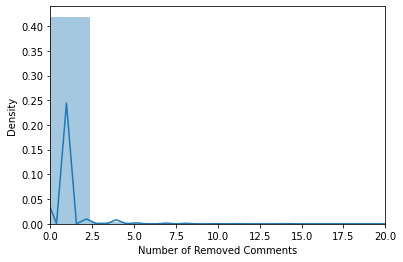

In [22]:
# Distribution of the number of users who post removed comments 
# Out of users who have at least one comment removed, how many are repeat offenders?
sns.distplot(users['Removed'])
plt.xlim(0,20)
plt.xlabel('Number of Removed Comments')
plt.ylabel('Density')
# plt.title("Distribution of Removed Comments by Users")
plt.savefig("imgs/rem_users_distr.png")
plt.show()

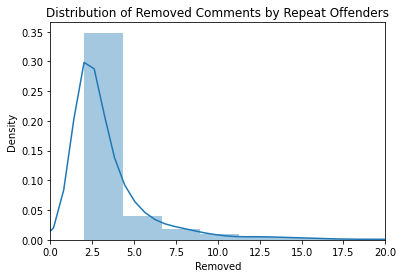

In [23]:
# Distribution of repeat offenders (the number of users who post more than 1 removed comment) 
sns.distplot(users[users['Removed']>1]['Removed'])
plt.xlim(0,20)
plt.title("Distribution of Removed Comments by Repeat Offenders")
plt.savefig("imgs/rep_offenders_distr.png")
plt.show()

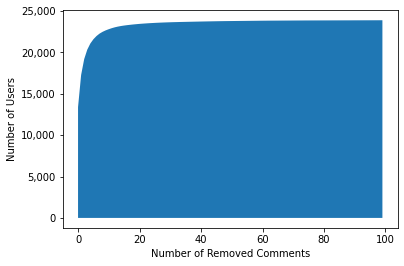

In [24]:
# cdf: users who post x or fewer comments
x = list()
sum_total = 0
for i in range(0,100):
    users_x = users[users['Removed']>i]['Removed'].count()
    sum_total += users_x
    x.append(sum_total)


x_ = np.arange(len(x))
fig, ax = plt.subplots(1,1); 
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.fill_between(x_, 0, x)
plt.ylabel("Number of Users")
plt.xlabel("Number of Removed Comments")
# plt.title("Cumulative Distribution of Removed Comments (User-Level)")
plt.savefig("imgs/cdf_users_removed.png")
plt.show()


#### For each user and comment date, I calculate the proportion of previously removed comments.

Moderators may punish "repeat offenders": if a given user has a historically high rate of comment removal, then moderators be more inclined to remove future comments from that user.

In [26]:
# generate running totals of removed and total comments by author and date of comment
comments_no_auth['count'] = 1
comments_no_auth.sort_values(['author','created_utc'],inplace=True)
comments_no_auth['run_rem'] = comments_no_auth.groupby('author').cumsum()['Removed']
comments_no_auth['run_tot'] = comments_no_auth.groupby('author').cumsum()['count']

In [27]:
comments_no_auth.drop(['count','index','level_0'],axis=1,inplace=True)
comments_no_auth.reset_index(inplace=True)

In [28]:
# generate running proportion of removed to total comments by author and date
comments_no_auth['run_prop_rem'] = comments_no_auth['run_rem']/comments_no_auth['run_tot']

# fill nans with 0
comments_no_auth['run_prop_rem'].fillna(0,inplace=True)

In [29]:
# generate running previous number removed, number total, and proportion of removed to total comments by author and date

comments_no_auth['run_prev_rem'] = comments_no_auth.groupby("author").shift(1)['run_rem']
comments_no_auth['run_prev_rem'].fillna(0,inplace=True)

comments_no_auth['run_prev_tot'] = comments_no_auth.groupby("author").shift(1)['run_tot']
comments_no_auth['run_prev_tot'].fillna(0,inplace=True)

comments_no_auth['run_prop_prev_rem'] = comments_no_auth.groupby("author").shift(1)['run_prop_rem']
comments_no_auth['run_prop_prev_rem'].fillna(0,inplace=True)

#### Flag first- through fifth-level responses to removed comments

Moderators may additionally remove responses to removed parent comments, regardless of the perceived "offensiveness" of such responses. To account for this, I flag immediate through fifth-level child responses to removed comments. 

In [30]:
# For each comment, parent_id refers to the parent comment or post immediately above
# Reformat parent ids to be consistent with comment ids
comments_no_auth['parent_id_2'] = comments_no_auth['parent_id'].apply(lambda x: x[3:])

# Self-join comments with respective parent comments: get only comments that have "parent" comments
# reformatted parent ids ("t1_" prefix) match with ids if they aren't top-level ("t3_" prefix)
# "_x" vars are parents, "_y" vars are children
comments_no_auth_1 = comments_no_auth.merge(right=comments_no_auth, left_on='id', right_on='parent_id_2')

In [31]:
# Get all parent ids that have been removed
comments_no_auth_2 = comments_no_auth_1.loc[comments_no_auth_1['Removed_x'] == 1]

# List immediate child comment ids of removed parent comments
comm_ids_to_be_removed = comments_no_auth_2['id_y'].values.tolist()

In [32]:
# Removed parent comments 
removed_par_comm = list(set(comments_no_auth_2['id_x']))

In [33]:
comments_no_auth['parent_prefix'] = comments_no_auth['parent_id'].apply(lambda x: x[:3])

# Flag immediate children of removed comments
comments_no_auth['child_rem_flag'] = comments_no_auth['id'].isin(comm_ids_to_be_removed).astype(int)

# Next flag children of these children (second-level responses to removed comments)
comments_no_auth_3 = comments_no_auth[comments_no_auth['child_rem_flag']==1]
comments_no_auth_3a = comments_no_auth_3.merge(right=comments_no_auth_3, left_on='id', right_on='parent_id_2')
comments_no_auth['child_rem_flag'].value_counts()

0    762823
1     15769
Name: child_rem_flag, dtype: int64

In [34]:
# Get all parent ids that have been removed

# List second-level child comment ids of removed parent comments
sec_comm_ids_to_be_removed = comments_no_auth_3a['id_y'].values.tolist()

# Flag second-level children of removed comments
comments_no_auth['sec_child_rem_flag'] = comments_no_auth['id'].isin(sec_comm_ids_to_be_removed).astype(int)
comments_no_auth['sec_child_rem_flag'].value_counts()

0    773487
1      5105
Name: sec_child_rem_flag, dtype: int64

In [35]:
# Next flag third-level chilren (third-level responses to removed comments)
comments_no_auth_4 = comments_no_auth[comments_no_auth['sec_child_rem_flag']==1]
comments_no_auth_4a = comments_no_auth_4.merge(right=comments_no_auth_4, left_on='id', right_on='parent_id_2')

# List third-level comment ids of removed parent comments
third_comm_ids_to_be_removed = comments_no_auth_4a['id_y'].values.tolist()

# Flag third-level children of removed comments
comments_no_auth['third_child_rem_flag'] = comments_no_auth['id'].isin(third_comm_ids_to_be_removed).astype(int)
comments_no_auth['third_child_rem_flag'].value_counts()

0    775297
1      3295
Name: third_child_rem_flag, dtype: int64

In [36]:
# Next flag fourth-level chilren (third-level responses to removed comments)
comments_no_auth_5 = comments_no_auth[comments_no_auth['third_child_rem_flag']==1]
comments_no_auth_5a = comments_no_auth_5.merge(right=comments_no_auth_5, left_on='id', right_on='parent_id_2')

# List fourth-level comment ids of removed parent comments
fourth_comm_ids_to_be_removed = comments_no_auth_5a['id_y'].values.tolist()

# Flag fourth-level children of removed comments
comments_no_auth['fourth_child_rem_flag'] = comments_no_auth['id'].isin(fourth_comm_ids_to_be_removed).astype(int)
comments_no_auth['fourth_child_rem_flag'].value_counts()

0    776483
1      2109
Name: fourth_child_rem_flag, dtype: int64

In [37]:
# Next flag fifth-level chilren (fifth-level responses to removed comments)
comments_no_auth_6 = comments_no_auth[comments_no_auth['fourth_child_rem_flag']==1]
comments_no_auth_6a = comments_no_auth_6.merge(right=comments_no_auth_6, left_on='id', right_on='parent_id_2')

# List fifth-level comment ids of removed parent comments
fifth_comm_ids_to_be_removed = comments_no_auth_6a['id_y'].values.tolist()

# Flag fifth-level children of removed comments
comments_no_auth['fifth_child_rem_flag'] = comments_no_auth['id'].isin(fifth_comm_ids_to_be_removed).astype(int)
comments_no_auth['fifth_child_rem_flag'].value_counts()

0    777191
1      1401
Name: fifth_child_rem_flag, dtype: int64

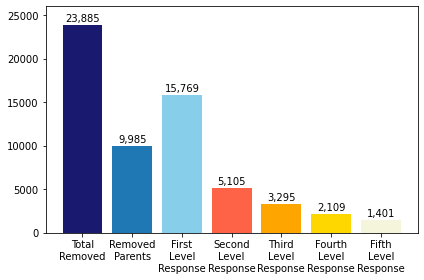

<Figure size 432x288 with 0 Axes>

In [38]:
# graph total, number, and proportion of first- through fifth-level responses
removed_comments = comments_no_auth[comments_no_auth['Removed']==1]
first_child_resp = comments_no_auth[comments_no_auth['child_rem_flag']==1]
sec_child_resp = comments_no_auth[comments_no_auth['sec_child_rem_flag']==1]
third_child_resp = comments_no_auth[comments_no_auth['third_child_rem_flag']==1]
fourth_child_resp = comments_no_auth[comments_no_auth['fourth_child_rem_flag']==1]
fifth_child_resp = comments_no_auth[comments_no_auth['fifth_child_rem_flag']==1]

def bar_labels_perc(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(
        f'{"{0:,}".format(round(float(height)*100,2))}%',                     
        (rect.get_x() + rect.get_width()/2, height),         
        xytext=(0, 2),         
        textcoords="offset points", 
        ha='center',                
        va='bottom') 

def bar_labels_count(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(
        f'{"{0:,}".format(round(int(height),0))}',                      
        (rect.get_x() + rect.get_width()/2, height),         
        xytext=(0, 2),          
        textcoords="offset points", 
        ha='center',                
        va='bottom')

fig,ax = plt.subplots()
rect0 = plt.bar("Total\nRemoved",removed_comments['id'].count(),color='midnightblue')
rect1 = plt.bar("Removed\nParents",len(removed_par_comm))
rect2 = plt.bar("First\nLevel\nResponse",first_child_resp['id'].count(),color='skyblue')
rect3 = plt.bar("Second\nLevel\nResponse",sec_child_resp['id'].count(),color='tomato')
rect4 = plt.bar("Third\nLevel\nResponse",third_child_resp['id'].count(),color='orange')
rect5 = plt.bar("Fourth\nLevel\nResponse",fourth_child_resp['id'].count(),color='gold')
rect6 = plt.bar("Fifth\nLevel\nResponse",fifth_child_resp['id'].count(),color='beige')

bar_labels_count(rect0)
bar_labels_count(rect1)
bar_labels_count(rect2)
bar_labels_count(rect3)
bar_labels_count(rect4)
bar_labels_count(rect5)
bar_labels_count(rect6)
# plt.title("Children of Removed Comments")

ax.set_ylim(0,26000)
fig.tight_layout()
plt.savefig('imgs/children_removed_comments.png')
plt.show()

#### About 45% of first-level children of removed parent comments also get removed

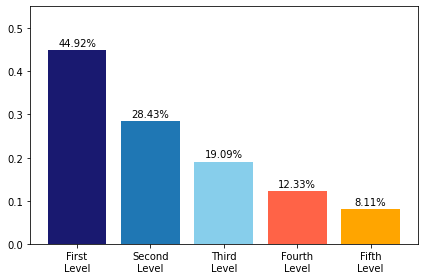

<Figure size 432x288 with 0 Axes>

In [39]:
# Get proportion of removed first- through third-level child comments

rem_first_child_resp = first_child_resp[first_child_resp['Removed']==1]['id'].count()
rem_sec_child_resp = sec_child_resp[sec_child_resp['Removed']==1]['id'].count()
rem_third_child_resp = third_child_resp[third_child_resp['Removed']==1]['id'].count()
rem_fourth_child_resp = fourth_child_resp[fourth_child_resp['Removed']==1]['id'].count()
rem_fifth_child_resp = fifth_child_resp[fifth_child_resp['Removed']==1]['id'].count()


first_prop = rem_first_child_resp/first_child_resp['id'].count()
sec_prop = rem_sec_child_resp/first_child_resp['id'].count()
third_prop = rem_third_child_resp/first_child_resp['id'].count()
fourth_prop = rem_fourth_child_resp/first_child_resp['id'].count()
fifth_prop = rem_fifth_child_resp/first_child_resp['id'].count()


fig,ax = plt.subplots()
rect1 = plt.bar("First\nLevel",first_prop, color='midnightblue')
rect2 = plt.bar("Second\nLevel",sec_prop)
rect3 = plt.bar("Third\nLevel",third_prop, color='skyblue')
rect4 = plt.bar("Fourth\nLevel",fourth_prop, color='tomato')
rect5 = plt.bar("Fifth\nLevel",fifth_prop, color='orange')


bar_labels_perc(rect1)
bar_labels_perc(rect2)
bar_labels_perc(rect3)
bar_labels_perc(rect4)
bar_labels_perc(rect5)

# plt.title("Proportion of Responses to Removed Comments That Are Also Removed")

ax.set_ylim(0,0.55)
fig.tight_layout()
plt.savefig('imgs/proportion_removed_child_comments.jpg')
plt.show()

In [40]:
# comments_final = pd.read_pickle("data/comments_final_.pkl")

### Proportion of Removed vs. Intact Comments

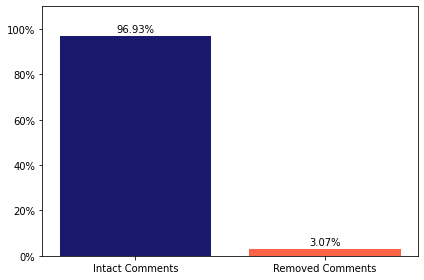

In [41]:
# Plot proportions of each class
y = comments_no_auth['Removed']
fig,ax = plt.subplots()


rect1 = plt.bar("Intact Comments",(len(y)-y.sum())/len(y), color='midnightblue')
rect2 = plt.bar("Removed Comments",y.sum()/len(y), color='tomato')

bar_labels_perc(rect1)
bar_labels_perc(rect2)


ax.set_ylim(0,1.1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
fig.tight_layout()
plt.savefig("imgs/class_imbalance.png")
plt.show()

In [42]:
# comments_final not stored due to file size
comments_final = comments_no_auth
comments_final.to_pickle('data/comments_final_.pkl')

## Part 3: Additional EDA

I also created variables indicating the word and character length for each comment, and investigated the impact of scores. 

In [43]:
comments_final['char_length'] = comments_final['body'].str.len()
comments_final['word_length'] = comments_final['body'].str.split().str.len()

However, there don't seem to be significant differences in the distribution of word/character length and scores between removed and intact comments.

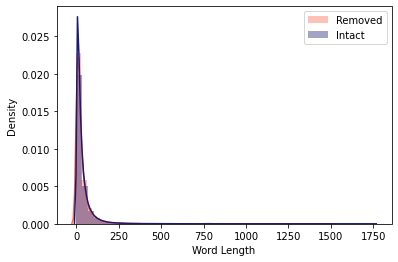

In [44]:
sns.distplot(comments_final[comments_final['Removed']==1]['word_length'],color='tomato',label='Removed')
sns.distplot(comments_final[comments_final['Removed']==0]['word_length'],color='midnightblue',label='Intact')
plt.legend()
plt.xlabel('Word Length')
plt.savefig('imgs/word_length.png')
# plt.Dititle("stribution of Word Length: Removed vs. Intact Comments")
plt.show()

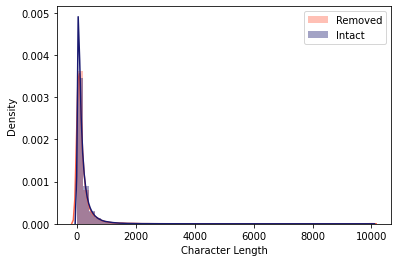

In [45]:
sns.distplot(comments_final[comments_final['Removed']==1]['char_length'],color='tomato',label='Removed')
sns.distplot(comments_final[comments_final['Removed']==0]['char_length'],color='midnightblue',label='Intact')
plt.legend()
plt.xlabel('Character Length')
plt.savefig('imgs/char_length.png')
# plt.title("Distribution of Character Length: Removed vs. Intact Comments")
plt.show()

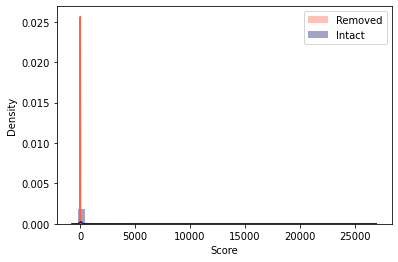

In [46]:
sns.distplot(comments_final[comments_final['Removed']==1]['score'],color='tomato',label='Removed')
sns.distplot(comments_final[comments_final['Removed']==0]['score'],color='midnightblue',label='Intact')
plt.legend()
plt.xlabel('Score')
plt.savefig('imgs/score.png')
# plt.title("Distribution of Comment Score: Removed vs. Intact Comments")
plt.show()

#### Wordcloud: Removed Words

In [47]:
corpus = comments_final['body_clean_stop'].values.tolist()
# del comments_final

In [48]:
rem_comments = comments_final[comments_final['Removed']==1]
corpus = rem_comments['body_clean_no_stop'].values.tolist()

vectorizer = TfidfVectorizer(max_features=500)
vecs = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

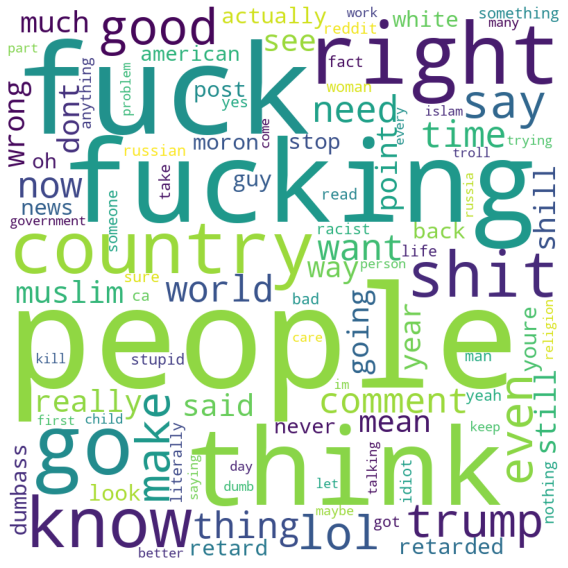

<Figure size 432x288 with 0 Axes>

In [49]:
Cloud = WordCloud(width = 800, height = 800, background_color="white", max_words=100).generate_from_frequencies(df.T.sum(axis=1))
plt.figure(figsize=(8,8))
plt.imshow(Cloud)
plt.axis("off")
plt.tight_layout() 
plt.show()
plt.savefig('imgs/removed_wordcloud.png')

In [3]:
# comments_final = pd.read_pickle('data/comments_final_.pkl')

#### Wordcloud: Intact Words

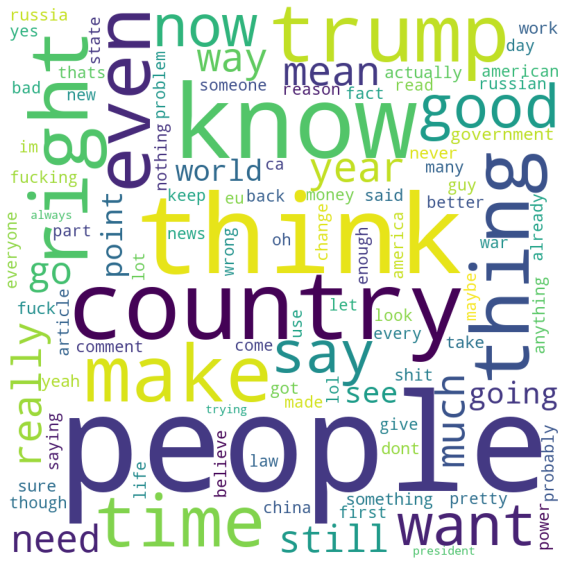

<Figure size 432x288 with 0 Axes>

In [4]:
stay_comments = comments_final[comments_final['Removed']==0]
corpus = stay_comments['body_clean_no_stop'].values.tolist()

vectorizer = TfidfVectorizer(max_features=500)
vecs = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)

Cloud = WordCloud(width = 800, height = 800, background_color="white", max_words=100).generate_from_frequencies(df.T.sum(axis=1))
plt.figure(figsize=(8,8))
plt.imshow(Cloud)
plt.axis("off")
plt.tight_layout() 
plt.show()
plt.savefig('imgs/intact_wordcloud.png')

### Pretrained Embeddings (Wikipedia): Word Associations 

In [5]:
lines = comments_final['body_clean_stop'].values.tolist()
word_lines = [line.split() for line in lines]

In [6]:
model_wv = gensim.models.KeyedVectors.load_word2vec_format('data/enwiki_20180420_300d.txt', binary=False)

Based on the pre-trained Wikipedia embeddings, let's see what some of the most similar words to the most "important" words in our corpus are using cosine similarity.

In [21]:
def plot_similar_words(word,palette):
    word_lst = list()
    vals = list()
    for w in model_wv.wv.most_similar(word,topn=7):
        word_lst.append(w[0])
        vals.append(w[1])

    think = sns.barplot(x=word_lst,y=vals,palette=palette)
    plt.setp(think.get_xticklabels(), rotation=45)

    plt.title(f'Most Similar Words to "{word.capitalize()}"')
    plt.tight_layout()
    plt.savefig(f'imgs/{word}_sim.png')
    plt.show()

Although there are a few interesting ones, most of these words seem to be semantically similar to their respective root words. 

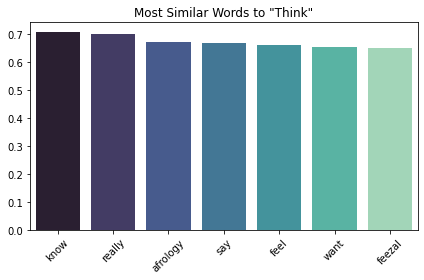

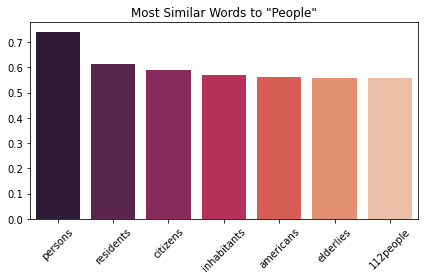

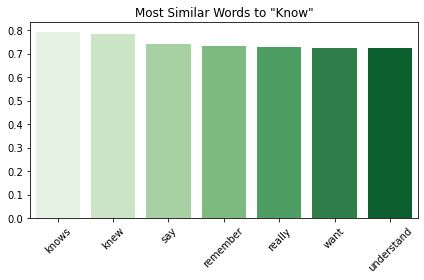

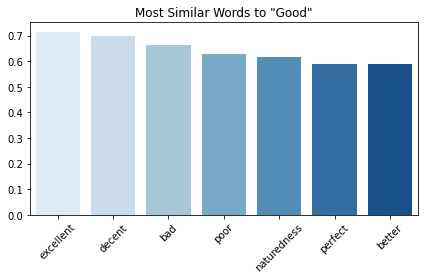

In [22]:
plot_similar_words('think','mako')
plot_similar_words('people','rocket')
plot_similar_words('know','Greens')
plot_similar_words('good','Blues')

In [9]:
EMBEDDING_DIM = 300
embeddings = np.zeros((len(model_wv.wv.index2word), EMBEDDING_DIM))
for i in range(0, len(model_wv.wv.index2word)):
    w = model_wv.wv.index2word[i]
    embeddings[i] = model_wv.wv[w]

In [10]:
lookup_words = ["people", "think", "know", "good"]
words_to_visualize = [] # Save for visualization below

for w in lookup_words:
    print(w)
    for s in model_wv.wv.most_similar([w]):
        print(s)
        words_to_visualize.append(s[0])

people
('persons', 0.7408679127693176)
('residents', 0.6150849461555481)
('citizens', 0.590334951877594)
('inhabitants', 0.5685606002807617)
('americans', 0.5609123706817627)
('elderlies', 0.5595462918281555)
('112people', 0.5594011545181274)
('tangbotens', 0.5562300682067871)
('individuals', 0.5553918480873108)
('youths', 0.5520451068878174)
think
('know', 0.706223726272583)
('really', 0.699171781539917)
('afrology', 0.6708520650863647)
('say', 0.6692708730697632)
('feel', 0.6622517108917236)
('want', 0.6543282866477966)
('feezal', 0.6497756242752075)
('believe', 0.6456776261329651)
('thinking', 0.6419878005981445)
('outdance', 0.6405911445617676)
know
('knows', 0.7925859689712524)
('knew', 0.7828781604766846)
('say', 0.7384178638458252)
('remember', 0.7326700091362)
('really', 0.7260110378265381)
('want', 0.7231899499893188)
('understand', 0.7225725054740906)
('어떡해', 0.7085976004600525)
('knowing', 0.7081158757209778)
('think', 0.706223726272583)
good
('excellent', 0.7161592841148376

In [14]:
# visualize embeddings in 2-dimensional space using SVD

svd = TruncatedSVD(n_components=2, algorithm='randomized', n_iter=500, random_state=101)
embeddings_2d_projection = svd.fit_transform(embeddings)

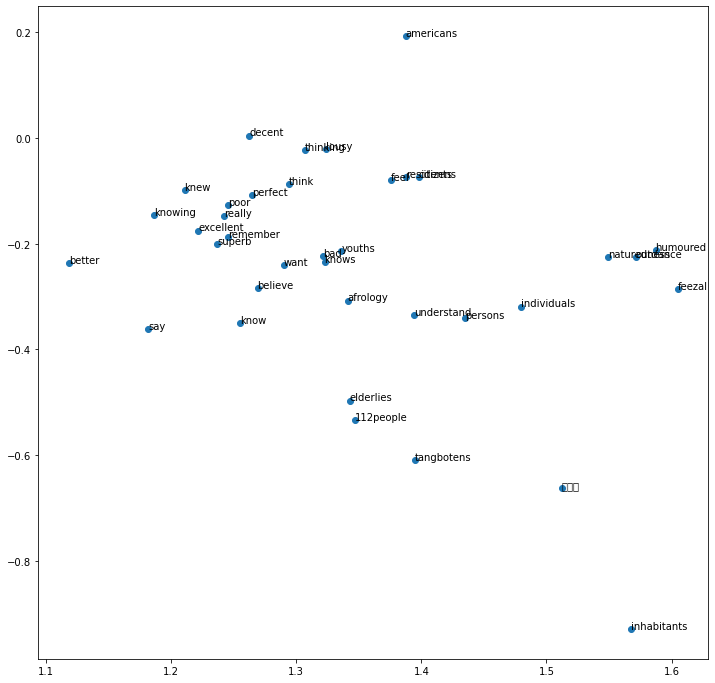

In [20]:
sample = np.in1d(model_wv.wv.index2word, words_to_visualize)
x = embeddings_2d_projection[sample,0]
y = embeddings_2d_projection[sample,1]
plt.figure(figsize=(12,12))
plt.scatter(x, y)
for i, txt in enumerate([model_wv.wv.index2word[i] for i in np.where(sample)[0]]):
    plt.annotate(txt, (x[i], y[i]))

#### Correlation of features with target

In [85]:
comments_final.columns

Index(['index', 'score', 'subreddit', 'parent_id', 'id', 'created_utc',
       'Removed', 'body', 'author', 'body_no_quotes', 'body_norm',
       'body_norm_mod', 'body_clean_no_stop', 'body_clean_stop', 'run_rem',
       'run_tot', 'run_prop_rem', 'run_prev_rem', 'run_prev_tot',
       'run_prop_prev_rem', 'parent_id_2', 'parent_prefix', 'child_rem_flag',
       'sec_child_rem_flag', 'third_child_rem_flag', 'fourth_child_rem_flag',
       'fifth_child_rem_flag'],
      dtype='object')

Although the running proportion of removed to total comment variables by author and date are highly correlated with the "Removed" target variable, including these in the model would introduce data leakage. The next best alternative is to include the running **previous** removed, total, and proportion variables.

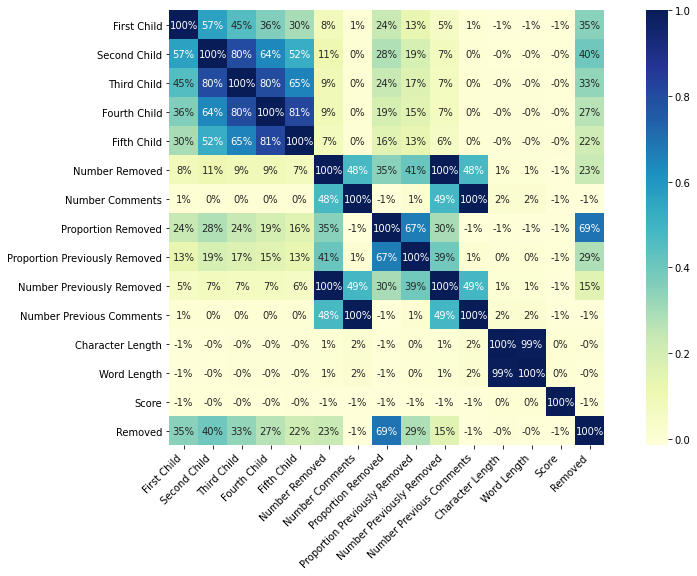

In [327]:
rename = {"child_rem_flag": "First Child", "sec_child_rem_flag": "Second Child", "third_child_rem_flag": "Third Child", "fourth_child_rem_flag": "Fourth Child", "fifth_child_rem_flag": "Fifth Child", "run_rem": "Number Removed", "run_tot": "Number Comments", "run_prop_rem": "Proportion Removed", "run_prev_rem": "Number Previously Removed", "run_prev_tot": "Number Previous Comments", "run_prop_prev_rem": "Proportion Previously Removed", "score": "Score", "char_length": "Character Length", "word_length": "Word Length"}
comments_final_corr = comments_final[['child_rem_flag', 'sec_child_rem_flag', 'third_child_rem_flag','fourth_child_rem_flag','fifth_child_rem_flag','run_rem', 'run_tot', 'run_prop_rem','run_prop_prev_rem', 'run_prev_rem', 'run_prev_tot','char_length','word_length','score','Removed']]
comments_final_corr.rename(columns = rename, inplace=True)
fig, ax = plt.subplots(figsize=(15, 8))
corr = comments_final_corr.corr()
corr_chart = sns.heatmap(corr, annot=True,mask=np.zeros_like(corr, dtype=np.bool), cmap='YlGnBu',
            square=True, ax=ax, fmt='0.0%')

corr_chart.set_xticklabels(corr_chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig('num_features_corr.png')
plt.show()

The set of final features is below.

In [287]:
final_features = ['child_rem_flag', 'sec_child_rem_flag', 'third_child_rem_flag','fourth_child_rem_flag','fifth_child_rem_flag','run_prop_prev_rem', 'run_prev_rem','run_prev_tot']